In [ ]:
!pip install chars2vec
!pip install -U sentence-transformers
import chars2vec
chars2vec_model = chars2vec.load_model('data/Auth2Vec_model')
from sentence_transformers import SentenceTransformer
bert_model = SentenceTransformer('distilbert-base-nli-mean-tokens')

import pickle
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import json
          
with open('data/features_names_list.pickle','rb') as file:
  features_names_list=pickle.load(file)
with open('data/labels_names_list.pickle','rb') as file:
  labels_names_list=pickle.load(file) 
with open('data/tagged_reference_list.pickle','rb') as file:
  tagged_reference_list=pickle.load(file)
with open('data/auth2index.pickle','rb') as file:
  auth2index=pickle.load(file) 
with open('data/index2auth.pickle','rb') as file:
  index2auth=pickle.load(file)
with open('data/venue_fullforms','rb') as file:
  venue_fullforms=pickle.load(file) 


     |████████████████████████████████| 8.1MB 6.6MB/s 
  Created wheel for chars2vec: filename=chars2vec-0.1.7-cp36-none-any.whl size=8111096 sha256=9d33606b4e52fa1b5b856ad144984b3986d3a73c1506cdf0f1517dd04dc84604
  Stored in directory: /root/.cache/pip/wheels/97/b6/65/d7e778ef1213ec77d315aea0f536068b96e36cc94c02abbfde
Successfully built chars2vec
     |████████████████████████████████| 71kB 5.8MB/s 
     |████████████████████████████████| 1.1MB 16.5MB/s 
     |████████████████████████████████| 1.1MB 21.7MB/s 
     |████████████████████████████████| 3.0MB 45.1MB/s 
     |████████████████████████████████| 890kB 51.3MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.8-cp36-none-any.whl size=101996 sha256=0c66c83b3dcc6df9f8ea85328ec2aa1dec61d5a483adb1d224c55621f6162ba4
  Stored in directory: /root/.cache/pip/wheels/27/ec/b3/d12cc8e4daf77846db6543033d3a5642f204c0320b15945647
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=8

100%|██████████| 245M/245M [00:09<00:00, 25.0MB/s]


In [ ]:
name_features = []
name_labels = []
for feat in features_names_list:
  ref_number = feat["ref_number"]
  Combo_number = feat["Combo_number"]
  np_feat = [ref_number,Combo_number]
  name_features.append(np_feat)

for lab in labels_names_list:
  name_labels.append(lab["Author_label"])

combo_number_to_sample={}

for feat in features_names_list:
  Combo_number = feat["Combo_number"]
  combo_number_to_sample[Combo_number] = feat

ref_number_to_sample={}

for feat in tagged_reference_list:
  ref_number = feat["ref_number"]
  ref_number_to_sample[ref_number] = feat

In [ ]:
with open('data/combo_number_to_sample.json', 'w', encoding='utf-8') as f:
  json.dump(combo_number_to_sample, f, ensure_ascii=False, indent=4)
with open('data/ref_number_to_sample.json', 'w', encoding='utf-8') as f:
  json.dump(ref_number_to_sample, f, ensure_ascii=False, indent=4)

In [ ]:
def generateEmbeddingAndActaulSamples(x,y):

  features = []
  labels = []
  feature_string_list = []
  label_string_list = []

  for i,j in zip(x,y):
    combo_number = i[1]
    sample = combo_number_to_sample[combo_number]
    author = sample["Author_style"]
    coauthor = sample["coauthor"]
    title = sample["Title"]
    journal = sample["journal"]
    
    
    auth_emb=chars2vec_model.vectorize_words([author])[0]
    coauth_emb = chars2vec_model.vectorize_words([coauthor])[0]
    title_emb=bert_model.encode(title)
    venue_fullform  = venue_fullforms[journal]
    venue_emb=bert_model.encode(venue_fullform)

    features.append(np.concatenate([auth_emb,coauth_emb,title_emb,venue_emb]))
    labels.append(auth2index[j])
    feature_string_list.append(sample)
    label_string_list.append(j)

  features = np.array(features)
  labels = np.array(labels)   
  return (features,labels,feature_string_list,label_string_list)

In [ ]:
name_x_train_val, name_x_test, name_y_train_val, name_y_test = train_test_split(name_features, name_labels, test_size=0.15, random_state=42,shuffle=True,stratify=name_labels)
name_x_train, name_x_validate, name_y_train, name_y_validate = train_test_split(name_x_train_val, name_y_train_val, test_size=0.17, random_state=42,shuffle=True,stratify=name_y_train_val)

X_train,Y_train,X_train_feature_strings,Y_train_label_strings = generateEmbeddingAndActaulSamples(name_x_train,name_y_train)
X_test,Y_test,X_test_feature_strings,Y_test_label_strings = generateEmbeddingAndActaulSamples(name_x_test,name_y_test)
X_validate,Y_validate,X_validate_feature_strings,Y_validate_label_strings = generateEmbeddingAndActaulSamples(name_x_validate,name_y_validate)

X_train = tf.keras.utils.normalize(X_train, axis = 1)
X_test = tf.keras.utils.normalize(X_test, axis = 1)
X_validate = tf.keras.utils.normalize(X_validate, axis = 1)

class_weights = class_weight.compute_class_weight('balanced',np.unique(Y_train), Y_train)
class_weights = dict(enumerate(class_weights))

In [ ]:
import json
def formFeatutreAndLabelStrings(feature_strings,label_strings,filepath):

  sample_and_target_list = []
  for i,j in zip(feature_strings,label_strings):
    sample_and_target_dict = {}
    sample_and_target_dict["ref_number"] = i["ref_number"]
    sample_and_target_dict["combo_number"] = i["Combo_number"]
    sample_and_target_dict["auth_style"] = i["Author_style"]
    sample_and_target_dict["coauth_style"] = i["coauthor"]
    sample_and_target_dict["journal"] = i["journal"]
    sample_and_target_dict["venue_fullform"] = i["venue_fullform"]
    sample_and_target_dict["target"] = j
    sample_and_target_list.append(sample_and_target_dict)

  with open(filepath+'.json', 'w', encoding='utf-8') as f:
    json.dump(sample_and_target_list, f, ensure_ascii=False, indent=4)    

In [ ]:
filepath = 'data/train_strings'
formFeatutreAndLabelStrings(X_train_feature_strings,Y_train_label_strings,filepath)

filepath = 'data/test_strings'
formFeatutreAndLabelStrings(X_test_feature_strings,Y_test_label_strings,filepath)

filepath = 'data/validation_strings'
formFeatutreAndLabelStrings(X_validate_feature_strings,Y_validate_label_strings,filepath)

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(128,activation = tf.nn.relu,input_dim=1936))
model.add(tf.keras.layers.Dense(128,activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(1523,activation = tf.nn.softmax))

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

best_model_path = 'data/Reference2Auth_model.h5'
es = EarlyStopping(monitor='val_loss', mode='min', patience=50,verbose=1)
mc = ModelCheckpoint(filepath=best_model_path, monitor='val_accuracy', mode='max', save_best_only=True,verbose=1)

history = model.fit(X_train,Y_train,epochs=500,validation_data=(X_validate,Y_validate),callbacks=[es, mc],class_weight=class_weights,shuffle=True)

Epoch 1/500
2942/2948 [============================>.] - ETA: 0s - loss: 4.3747 - accuracy: 0.1161
Epoch 00001: val_accuracy improved from -inf to 0.21977, saving model to /content/drive/My Drive/combined_ambig_references/combined_ambig_references_model.h5
2948/2948 [==============================] - 10s 3ms/step - loss: 4.3704 - accuracy: 0.1162 - val_loss: 3.2422 - val_accuracy: 0.2198
Epoch 2/500
2942/2948 [============================>.] - ETA: 0s - loss: 1.4491 - accuracy: 0.2537
Epoch 00002: val_accuracy improved from 0.21977 to 0.29287, saving model to /content/drive/My Drive/combined_ambig_references/combined_ambig_references_model.h5
2948/2948 [==============================] - 10s 3ms/step - loss: 1.4488 - accuracy: 0.2536 - val_loss: 2.6038 - val_accuracy: 0.2929
Epoch 3/500
2931/2948 [============================>.] - ETA: 0s - loss: 1.0185 - accuracy: 0.3698
Epoch 00003: val_accuracy improved from 0.29287 to 0.44983, saving model to /content/drive/My Drive/combined_ambig_r

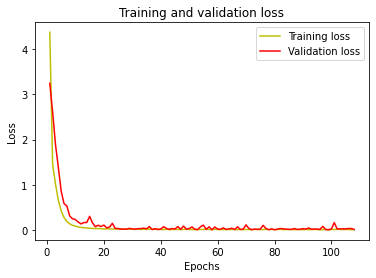

In [ ]:
from matplotlib import pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

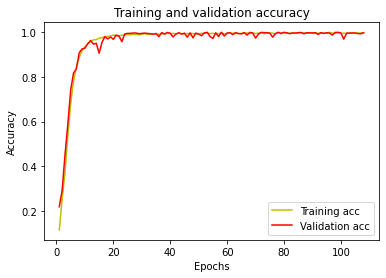

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Testing of the model
from sklearn.metrics import accuracy_score

saved_model = tf.keras.models.load_model('Reference2Auth_model.h5') 
predictions = saved_model.predict(X_test) 
Y_predict = np.argmax(predictions, axis=1) 
test_accuracy = accuracy_score(Y_test, Y_predict)

print("Test Accuracy : ",test_accuracy)

Test Accuracy :  0.9985038898862957


In [ ]:
# Save all the data to files for future visualisations
loss_file_path = "data/loss"
with open(loss_file_path,'wb') as file:
  pickle.dump(loss,file)
  
val_loss_file_path = "data/val_loss"
with open(val_loss_file_path,'wb') as file:
  pickle.dump(val_loss,file)

acc_file_path = "data/acc"
with open(acc_file_path,'wb') as file:
  pickle.dump(acc,file)
  
val_acc_file_path = "data/val_acc"
with open(val_acc_file_path,'wb') as file:
  pickle.dump(val_acc,file)

In [ ]:
!pip install pygal
!pip install cairosvg

     |████████████████████████████████| 133kB 10.0MB/s 


In [ ]:
# Visualisations for the report
import pygal  
from pygal.style import Style
import pickle
import math
import numpy as np

loss_file_path = "data/loss"
with open(loss_file_path,'rb') as file:
  train_loss = pickle.load(file)

val_loss_file_path = "data/val_loss"
with open(val_loss_file_path,'rb') as file:
  val_loss = pickle.load(file)

acc_file_path = "data/acc"
with open(acc_file_path,'rb') as file:
  train_acc = pickle.load(file)

val_acc_file_path = "data/val_acc"
with open(val_acc_file_path,'rb') as file:
  val_acc = pickle.load(file)

custom_style = Style(
    title_font_size=40,
    label_font_size = 35
)

## Plot Training and Validation loss
# Normal Plot
loss_line_chart = pygal.XY(x_title='Epochs',y_title='Loss',style=custom_style)
loss_line_chart.title = 'Training and Validation loss [bert]'
loss_line_chart.x_labels = range(0, len(train_loss)+10, 20)
loss_line_chart.y_labels = np.arange(0, math.ceil(max(train_loss))+0.5, 1)
loss_line_chart.add('train_loss', [(i+1,train_loss[i]) for i in range(len(train_loss))])
loss_line_chart.add('val_loss',  [(i+1,val_loss[i]) for i in range(len(train_loss))])
loss_line_chart.render_to_png('train_and_validation_loss_bert.png', human_readable=True)

# Log Plot
log_train_loss = [math.log(i) for i in train_loss]
log_val_loss = [math.log(i) for i in val_loss]
log_loss_line_chart = pygal.XY(x_title='Epochs',y_title='Log Loss',style=custom_style)
log_loss_line_chart.title = 'Training and Validation log loss [bert]'
log_loss_line_chart.x_labels = range(0, len(log_train_loss)+10, 20)
log_loss_line_chart.y_labels = np.arange(math.floor(min(log_train_loss)), math.ceil(max(log_train_loss))+0.5, 1)
log_loss_line_chart.add('train_log_loss', [(i+1,log_train_loss[i]) for i in range(len(log_train_loss))])
log_loss_line_chart.add('val_log_loss',  [(i+1,log_val_loss[i]) for i in range(len(log_train_loss))])
log_loss_line_chart.render_to_png('train_and_validation_log_loss_bert.png', human_readable=True)

## Plot Training and Validation Accuracy
# Normal Plot
acc_line_chart = pygal.XY(x_title='Epochs',y_title='Accuracy',style=custom_style)
acc_line_chart.title = 'Training and Validation Accuracy [bert]'
acc_line_chart.x_labels = range(0, len(train_acc)+10, 20)
acc_line_chart.y_labels = np.arange(0, math.ceil(max(train_acc))+0.2, 0.2)
acc_line_chart.add('train_acc', [(i+1,train_acc[i]) for i in range(len(train_acc))])
acc_line_chart.add('val_acc',  [(i+1,val_acc[i]) for i in range(len(train_acc))])
acc_line_chart.render_to_png('train_and_validation_accuracy_bert.png', human_readable=True)

# Log Plot
log_train_acc = [-1*math.log(1-i) for i in train_acc]
log_val_acc = [-1*math.log(1-i) for i in val_acc]
log_acc_line_chart = pygal.XY(x_title='Epochs',y_title='-Log(1 - Accuracy)',style=custom_style)
log_acc_line_chart.title = 'Training and Validation -log(1 - accuracy)  [bert]'
log_acc_line_chart.x_labels = range(0, len(log_train_acc)+10, 20)
log_acc_line_chart.y_labels = np.arange(math.floor(min(log_train_acc)), math.ceil(max(log_train_acc))+0.5, 1)
log_acc_line_chart.add('train_log_acc', [(i+1,log_train_acc[i]) for i in range(len(log_train_acc))])
log_acc_line_chart.add('val_log_acc',  [(i+1,log_val_acc[i]) for i in range(len(log_train_acc))])
log_acc_line_chart.render_to_png('train_and_validation_log_accuracy_bert.png', human_readable=True)